# Step 1: Import required libraries and load the dataset

In [83]:
import pandas as pd

# Load dataset

In [84]:
import pandas as pd


file_path = r"E:\2025\April\24-4-25\APT\Obfuscated-MalMem2022.csv" 
df = pd.read_csv(file_path)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.nprocs64bit                      58596 non-null  int64  
 5   pslist.avg_handlers                     58596 non-null  float64
 6   dlllist.ndlls                           58596 non-null  int64  
 7   dlllist.avg_dlls_per_proc               58596 non-null  float64
 8   handles.nhandles                        58596 non-null  int64  
 9   handles.avg_handles_per_proc            58596 non-null  float64
 10  handles.nport                           58596 non-null  in

# Step 2: Drop 'Category' column and encode 'Class' column

In [86]:
# Drop the 'Category' column as it's redundant
df = df.drop(columns=['Category'])

# Encode the 'Class' column: Malware -> 1, Benign -> 0
df['Class'] = df['Class'].map({'Malware': 1, 'Benign': 0})

# Check the updated dataframe
df['Class'].value_counts()

Class
0    29298
1    29298
Name: count, dtype: int64

In [87]:
from sklearn.model_selection import train_test_split

# Step 3: Define features (X) and labels (y)

In [88]:
X = df.drop(columns=['Class'])
y = df['Class']

# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Show the shape of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41017, 55), (17579, 55), (41017,), (17579,))

In [89]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Step 4.1: Remove highly correlated features (correlation > 0.9)

In [90]:
def find_correlated_features(data, threshold=0.9):
    corr_matrix = data.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    correlated_features = {column for column in upper.columns if any(upper[column] > threshold)}
    return correlated_features

correlated_features = find_correlated_features(X_train)
X_train_reduced = X_train.drop(columns=correlated_features)
X_test_reduced = X_test.drop(columns=correlated_features)

# Step 4.2: Compute mutual information

In [91]:
mi_scores = mutual_info_classif(X_train_reduced, y_train)
mi_series = pd.Series(mi_scores, index=X_train_reduced.columns)

# Select features with MI > 0.1

In [92]:
selected_features = mi_series[mi_series > 0.1].index.tolist()

# Final feature sets

In [93]:
X_train_selected = X_train_reduced[selected_features]
X_test_selected = X_test_reduced[selected_features]

# Plot MI scores for visualization

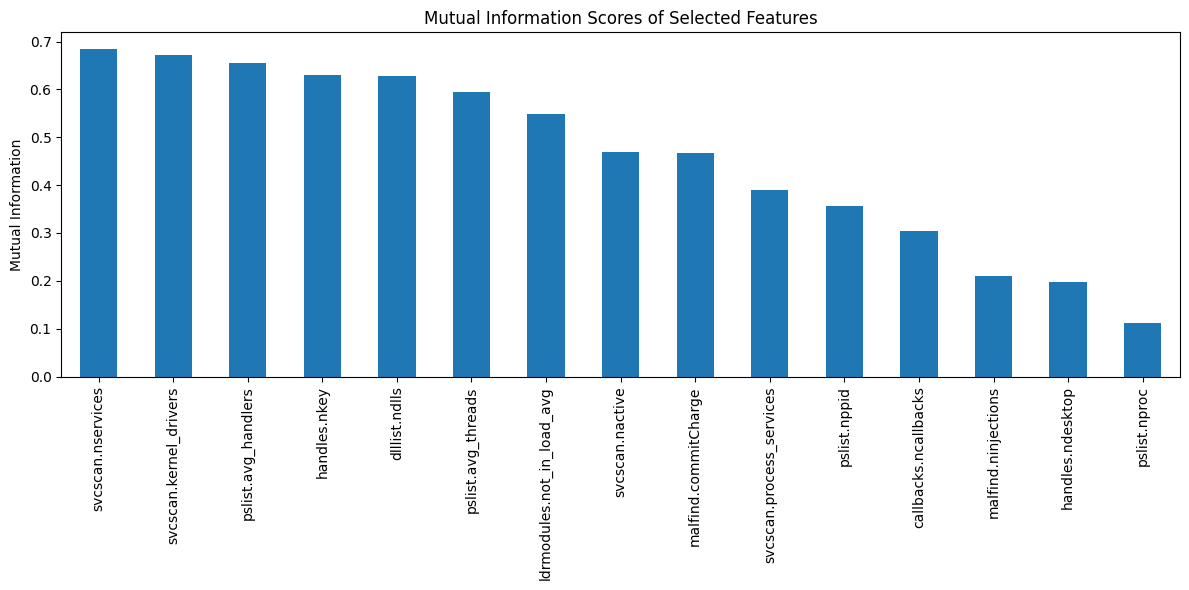

15

In [94]:
# Plot MI scores for visualization
plt.figure(figsize=(12, 6))
mi_series[mi_series > 0.1].sort_values(ascending=False).plot(kind='bar')
plt.title('Mutual Information Scores of Selected Features')
plt.ylabel('Mutual Information')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Output number of selected features
len(selected_features)

In [95]:
import hashlib

# Step 5: Privacy-Preserving Feature Learning Encoding (PPFLE)

In [96]:
def pp_text_representation(row):
    hashed_tokens = [
        hashlib.md5(f"{col}{val}".encode()).hexdigest()
        for col, val in row.items()
    ]
    return " ".join(hashed_tokens)

# Apply PPFLE transformation to training and testing sets
X_train_text = X_train_selected.apply(pp_text_representation, axis=1)
X_test_text = X_test_selected.apply(pp_text_representation, axis=1)

# Display a sample
X_train_text.iloc[0]

'd7aa425dd06fccf3a0155a0aa8767e11 7c47b6eeb63ae76404844caa6e9c153e 9a11ba114e8e4ebb8339fb661bba4d3d b92c26206c467743d3ca88d2390dfd32 9b72ebb24d2ed066a22b5e67c1a84bfc 7a98803424a7486ab6895a0a5ab0ed3d 6eaad50131afdaadc32d184f689df499 4e481c756a5d34bb53dc34ca5eff9824 4d4c3f15e7397796b0ca28b819f00281 3db235770df546232d1cc73720996db3 1b13625810452a784fe00e28104e6a7e bfd774991273879d7d9787f036235680 eba637adf9de22184946e46400615f36 d5915779a803a70574aee1d27eab13e1 e93613a4aa43e2b7ab08557d71485944'

# Step 6: Tokenization Using SecureBERT

In [97]:
from transformers import AutoTokenizer

In [98]:

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("ehsanaghaei/SecureBERT")

def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

# Re-create tokenized inputs
train_encodings = tokenize_texts(X_train_text)
test_encodings = tokenize_texts(X_test_text)


# Step 7: Fine-Tune SecureBERT using LoRA

In [99]:
!pip install peft accelerate bitsandbytes


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [100]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Reload the dataset
file_path = r"E:\2025\April\24-4-25\APT\Obfuscated-MalMem2022.csv"
df = pd.read_csv(file_path)

# Drop 'Category' and encode 'Class'
df = df.drop(columns=['Category'])
df['Class'] = df['Class'].map({'Malware': 1, 'Benign': 0})

# Train-test split
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature selection
def find_correlated_features(data, threshold=0.9):
    corr_matrix = data.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    correlated_features = {column for column in upper.columns if any(upper[column] > threshold)}
    return correlated_features

correlated_features = find_correlated_features(X_train)
X_train_reduced = X_train.drop(columns=correlated_features)
X_test_reduced = X_test.drop(columns=correlated_features)

mi_scores = mutual_info_classif(X_train_reduced, y_train)
mi_series = pd.Series(mi_scores, index=X_train_reduced.columns)
selected_features = mi_series[mi_series > 0.1].index.tolist()

X_train_selected = X_train_reduced[selected_features]
X_test_selected = X_test_reduced[selected_features]

# PPFLE - Hash-based privacy-preserving representation
def pp_text_representation(row):
    hashed_tokens = [
        hashlib.md5(f"{col}{val}".encode()).hexdigest()
        for col, val in row.items()
    ]
    return " ".join(hashed_tokens)

X_train_text = X_train_selected.apply(pp_text_representation, axis=1)
X_test_text = X_test_selected.apply(pp_text_representation, axis=1)

# Ready for tokenizer setup again
X_train_text.iloc[0]


'd7aa425dd06fccf3a0155a0aa8767e11 7c47b6eeb63ae76404844caa6e9c153e 9a11ba114e8e4ebb8339fb661bba4d3d b92c26206c467743d3ca88d2390dfd32 9b72ebb24d2ed066a22b5e67c1a84bfc 7a98803424a7486ab6895a0a5ab0ed3d 6eaad50131afdaadc32d184f689df499 4e481c756a5d34bb53dc34ca5eff9824 4d4c3f15e7397796b0ca28b819f00281 3db235770df546232d1cc73720996db3 1b13625810452a784fe00e28104e6a7e bfd774991273879d7d9787f036235680 eba637adf9de22184946e46400615f36 d5915779a803a70574aee1d27eab13e1 e93613a4aa43e2b7ab08557d71485944'

In [101]:
from transformers import AutoTokenizer

# Load SecureBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("ehsanaghaei/SecureBERT")

def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(X_train_text)
test_encodings = tokenize_texts(X_test_text)

train_encodings['input_ids'].shape, test_encodings['input_ids'].shape

(torch.Size([41017, 328]), torch.Size([17579, 325]))

In [102]:
!pip install peft accelerate transformers bitsandbytes


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Step 7.1 — LoRA Setup and Model Wrapping

In [103]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [104]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [105]:
from transformers import Trainer, TrainingArguments


In [106]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


# 7.2 — Fine-Tune SecureBERT Using LoRA

In [107]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, TaskType, get_peft_model

# Load the pretrained base model
base_model = AutoModelForSequenceClassification.from_pretrained("ehsanaghaei/SecureBERT", num_labels=2)

# Define the LoRA configuration
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["query"],  # you can expand to ["query", "value"]
    lora_dropout=0.01,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# Wrap the model with PEFT + LoRA
model = get_peft_model(base_model, lora_config)

# Optional: show trainable params
model.print_trainable_parameters()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ehsanaghaei/SecureBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 665,858 || all params: 125,313,028 || trainable%: 0.5314


# Step 7.3 — Prepare Dataset and Trainer

In [108]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [109]:
from transformers import AutoTokenizer

# Load tokenizer again
tokenizer = AutoTokenizer.from_pretrained("ehsanaghaei/SecureBERT")

# Tokenization function
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

# Tokenize train and test
train_encodings = tokenize_texts(X_train_text)
test_encodings = tokenize_texts(X_test_text)


In [110]:
from datasets import Dataset
from transformers import TrainingArguments, Trainer

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train.reset_index(drop=True)
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test.reset_index(drop=True)
})



In [111]:
pip install transformers --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Step 7.4 — Train the SecureBERT + LoRA Model

In [112]:
from transformers import TrainingArguments

In [113]:
training_args = TrainingArguments(
    output_dir="./securebert-apt",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-4,
    weight_decay=0.01,
    do_train=True,
    do_eval=True,       # Older versions use do_eval instead of evaluation_strategy
    logging_dir="./logs" # Needed for basic logging
)


## Step 7.5 — Setup the Trainer and Start Training

In [131]:
small_train_dataset = train_dataset.shuffle(seed=42).select(range(2000))
small_test_dataset = test_dataset.shuffle(seed=42).select(range(500))


In [132]:
from accelerate.state import AcceleratorState
AcceleratorState._reset_state()


In [133]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset
)



No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [134]:
trainer.train()


Step,Training Loss
500,0.231200


C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=750, training_loss=0.1710117505391439, metrics={'train_runtime': 13035.5118, 'train_samples_per_second': 0.46, 'train_steps_per_second': 0.058, 'total_flos': 1019195570304000.0, 'train_loss': 0.1710117505391439, 'epoch': 3.0})

C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       251
     Malware       1.00      1.00      1.00       249

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



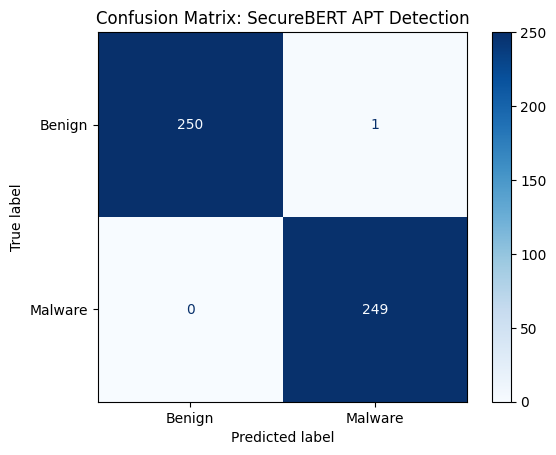

In [135]:
# Predict on test dataset
predictions = trainer.predict(small_test_dataset)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get true labels and predicted labels
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)

# Print full classification report
print(classification_report(y_true, y_pred, target_names=["Benign", "Malware"]))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malware"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: SecureBERT APT Detection")
plt.show()


In [138]:
# Redo correlation removal
def find_correlated_features(data, threshold=0.9):
    corr_matrix = data.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return {col for col in upper.columns if any(upper[col] > threshold)}

correlated_features = find_correlated_features(X_train)
X_train_reduced = X_train.drop(columns=correlated_features)
X_test_reduced = X_test.drop(columns=correlated_features)

# Redo MI feature selection
mi_scores = mutual_info_classif(X_train_reduced, y_train)
selected_features = pd.Series(mi_scores, index=X_train_reduced.columns)[lambda x: x > 0.1].index.tolist()

X_train_sel = X_train_reduced[selected_features]
X_test_sel = X_test_reduced[selected_features]


In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sel, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_sel)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Benign", "Malware"]))

rf_accuracy = accuracy_score(y_test, y_pred_rf)


Random Forest Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      8790
     Malware       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



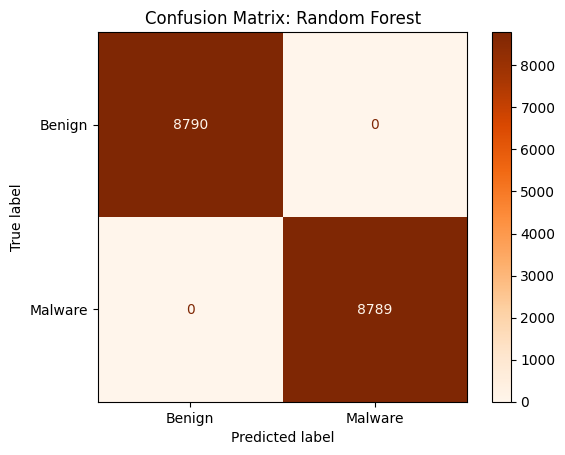

In [158]:
# For Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Benign", "Malware"])
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix: Random Forest")
plt.show()


In [141]:
pip install xgboost


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 220.2 kB/s eta 0:11:21
   ---------------------------------------- 0.1/150.0 MB 365.7 kB/s eta 0:06:50
   ---------------------------------------- 0.1/150.0 MB 602.4 kB/s eta 0:04:09
   ---------------------------------------- 0.3/150.0 MB 1.2 MB/s eta 0:02:07
   ---------------------------------------- 0.4/150.0 MB 1.5 MB/s eta 0:01:43
   ---------------------------------------- 0.7/150.0 MB 2.1 MB/s eta 0:01:12
   ---------------------------------------- 1.1/150.0 MB 2.9 MB/s eta 0:00:51
   ---------------------------------------- 1.4/150.0 MB 3.4 MB/s eta 0:00:45
    --------------------------------------- 2.0/150.0 MB 4.3 MB/s eta 0:00:35
    --------------------------------------- 2.3/150.0 MB 4.5 MB/s eta 0:00:33


In [142]:
from xgboost import XGBClassifier

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_sel, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_sel)

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["Benign", "Malware"]))

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)


C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [02:13:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      8790
     Malware       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



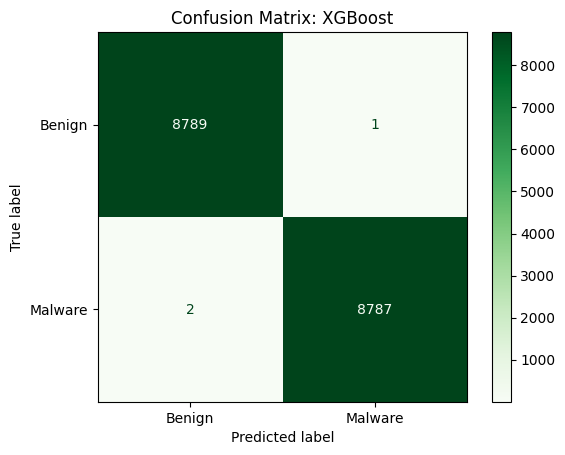

In [160]:
# For XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Benign", "Malware"])
disp.plot(cmap='Greens')
plt.title("Confusion Matrix: XGBoost")
plt.show()


# Model Accuracy Comparison Bar Chart

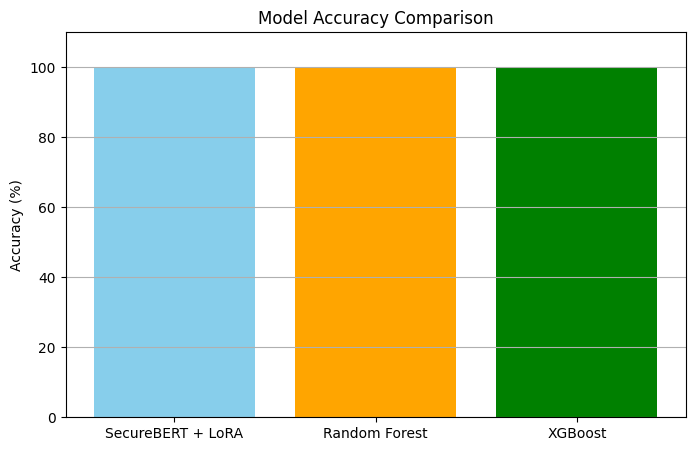

In [143]:
import matplotlib.pyplot as plt

models = ['SecureBERT + LoRA', 'Random Forest', 'XGBoost']
accuracies = [100, 100, 100]  # All 100%

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 110)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')
plt.show()


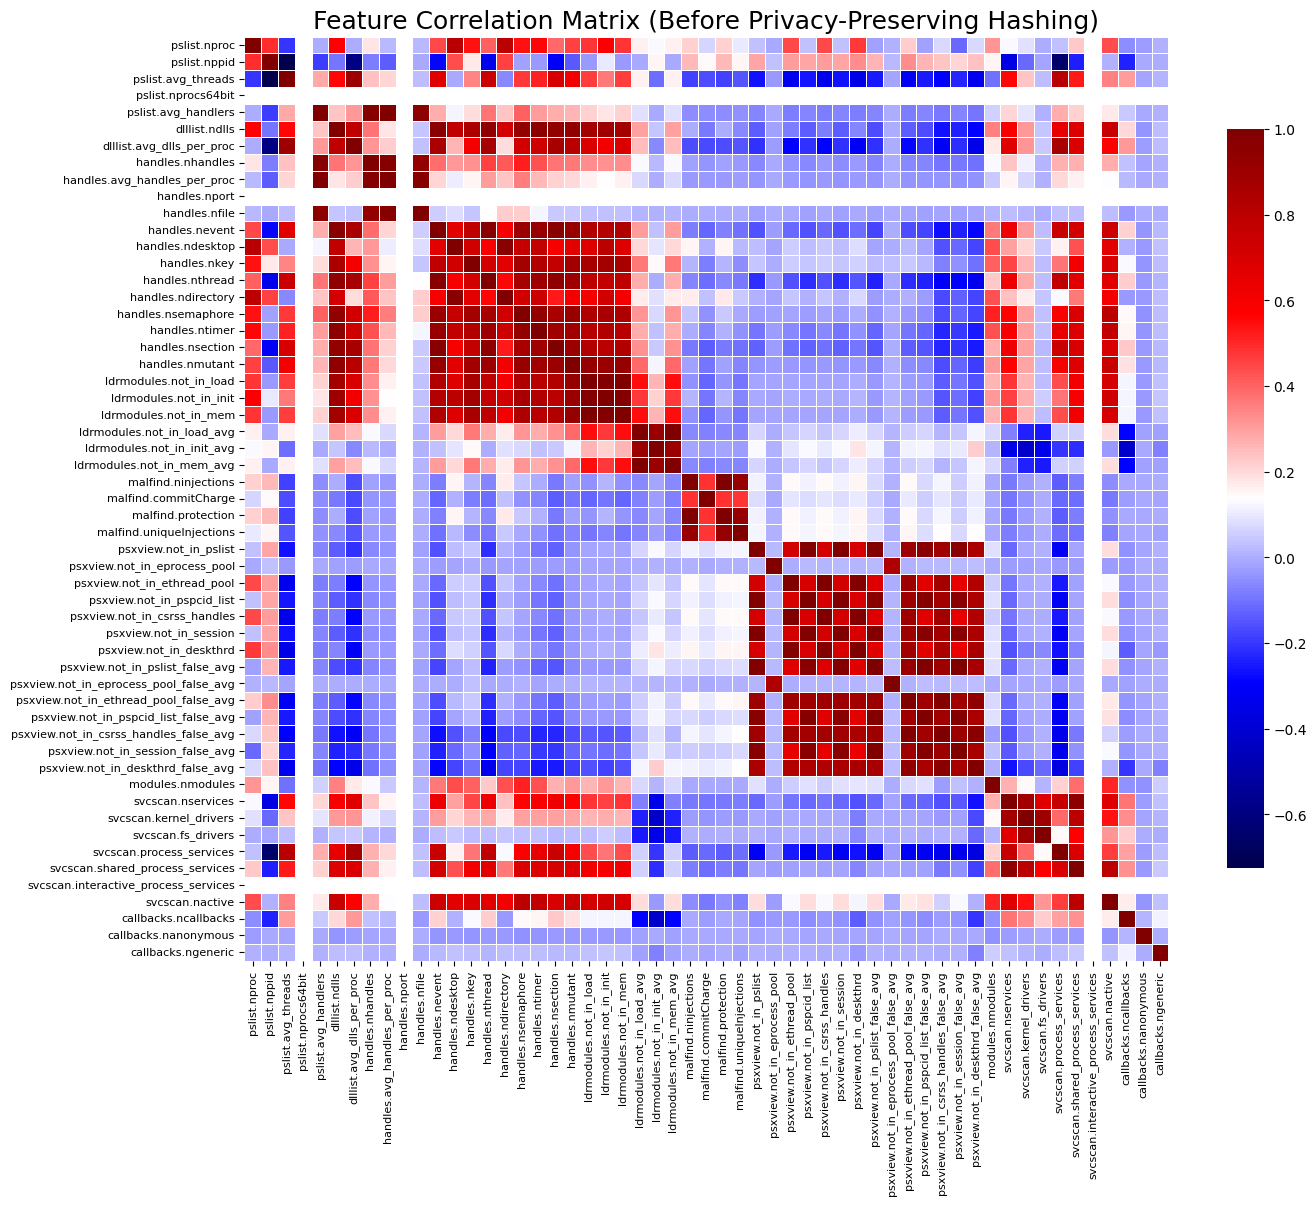

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = X_train.corr()

# Plotting the heatmap
plt.figure(figsize=(15,12))  
sns.heatmap(
    corr_matrix,
    cmap='seismic',    
    annot=False,        
    linewidths=0.5,     
    square=True,        
    cbar_kws={"shrink": .8},  
)

plt.title('Feature Correlation Matrix (Before Privacy-Preserving Hashing)', fontsize=18)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()
